## Visualization of outputs and interpolation methods

[Model Viz](#model-visualization)

[Model Interpolation](#interpolation)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from models.vae import VAE, Encoder, Decoder, VAE_convT
import torch
import glob
import re

import h5py

In [344]:
# Coonvert and transpose to tensor
def prepare_image(image):
    image = np.transpose(image, (0, 4, 1, 2, 3))
    image = torch.from_numpy(image).float()
    return image


def viz(images, model_path, c = 1, t = 3, scale_colorbar = False, i1 = 32, i2 = 96):    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #match = re.search(r'zdim(\d+)', model_path)
    #model = VAE(z_dim=match.group(1), in_channels=4, gf_dim=8).to(device)
    model = VAE_convT(in_channels=4, gf_dim=8).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    image1 = prepare_image(images[i1:i1+1])
    image2 = prepare_image(images[i2:i2+1])
    input_dict1 = {"input_images": image1}
    input_dict2 = {"input_images": image2}
    output_dict1 = model(input_dict1)
    output_dict2 = model(input_dict2)
    decoder_output1 = output_dict1['decoder_output']
    decoder_output2 = output_dict2['decoder_output']
    z_mean1 = output_dict1['mu']
    z_std1 = output_dict1['z_std']
    z_mean2 = output_dict2['mu']
    z_std2 = output_dict2['z_std']
    # Sample from the latent space
    latent_vector1 = z_mean1 + z_std1 * torch.randn_like(z_mean1)
    latent_vector2 = z_mean2 + z_std2 * torch.randn_like(z_mean2)
    interpolation_factor = torch.arange(0,1,0.1)
    interpolated_latent_vector = latent_vector1 * (1 - interpolation_factor)[:, None, None, None, None] + latent_vector2 * interpolation_factor[:, None, None, None, None]
    print(interpolated_latent_vector.shape)
    # Decode the latent vector
    outputs = model.decoder(interpolated_latent_vector)
    print(outputs.shape)
    # Show the inputs
    fig, axs = plt.subplots(1,2, figsize = (7,3))
    ax = axs.ravel()
    if scale_colorbar:
        plt.colorbar(ax[0].imshow(image1[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
        plt.colorbar(ax[1].imshow(image2[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
    else:
        ax[0].imshow(image1[0,c,:,:,t].detach().numpy())
        ax[1].imshow(image2[0,c,:,:,t].detach().numpy())
    fig.suptitle('Inputs')
    plt.tight_layout()
    plt.show()
    # Show the decoder outputs
    fig, axs = plt.subplots(1,2, figsize = (7,5))
    ax = axs.ravel()
    if scale_colorbar:
        plt.colorbar(ax[0].imshow(decoder_output1[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
        plt.colorbar(ax[1].imshow(decoder_output2[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
    else:
        ax[0].imshow(decoder_output1[0,c,:,:,t].detach().numpy())
        ax[1].imshow(decoder_output2[0,c,:,:,t].detach().numpy())
    fig.suptitle('Model outputs')
    plt.tight_layout()
    plt.show()
    # Show both inputs and outputs together on top of each other for both images
    fig, axs = plt.subplots(2,2, figsize = (8,5))
    ax = axs.ravel()
    if scale_colorbar:
        plt.colorbar(ax[0].imshow(image1[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
        plt.colorbar(ax[1].imshow(decoder_output1[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
        plt.colorbar(ax[2].imshow(image2[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
        plt.colorbar(ax[3].imshow(decoder_output2[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
        
    else:
        # Set title for each subplot
        ax[0].imshow(image1[0,c,:,:,t].detach().numpy())
        ax[1].imshow(decoder_output1[0,c,:,:,t].detach().numpy())
        ax[2].imshow(image2[0,c,:,:,t].detach().numpy())
        ax[3].imshow(decoder_output2[0,c,:,:,t].detach().numpy())
    ax[0].set_title('Inputs', fontsize = 16)
    ax[1].set_title('Model outputs', fontsize = 16)
    #fig.suptitle('Inputs and outputs')
    plt.tight_layout()
    plt.show()


    fig, axs = plt.subplots(1,10, figsize = (20,12))
    ax = axs.ravel()
    for i in range(10):
        if scale_colorbar:
            #plt.colorbar(ax[i].imshow(outputs[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
            ax[i].imshow(outputs[i,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5)
        else:
            ax[i].imshow(outputs[i,c,:,:,t].detach().numpy())
        ax[i].set_title(r'$\alpha$' + ' = '+ f'{interpolation_factor[i]:.1f}', fontsize = 20)
        ax[i].axis('off')
    plt.show()


In [362]:
# Load data
data = h5py.File('/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/data/test_masked_sliced_images_from_0_to_20.hdf5', 'r')
print(data.keys())
images = data['sliced_images_test']
print(images.shape)

<KeysViewHDF5 ['labels_test', 'sliced_images_test']>
(1280, 32, 32, 24, 4)


#### Model Visualization

In [363]:
sweep = ''
log_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/logs/vae_convT/masked_slice'
if sweep:
    log_path = os.path.join(log_path, sweep)
experiments = os.listdir(log_path)
experiments[-25:]

['20230703-2144_vae_convT_masked_slice_SSL_lr1.000e-03-e800-bs8-gf_dim8-daFalse_with_interpolation_training_imagewise',
 '20230719-1833_vae_convT_masked_slice_SSL_lr1.000e-03-e1500-bs8-gf_dim8-daFalse_2Dslice_decreased_interpolation_factor_cube_3',
 '20230719-1850_vae_convT_masked_slice_SSL_lr1.000e-03-e1500-bs8-gf_dim8-daFalse_poisson_mix_training_2Dslice_decreased_interpolation_factor_cube_3',
 '20230720-0841_vae_convT_masked_slice_SSL_lr1.000e-03-e1500-bs8-gf_dim8-daFalse_2Dslice',
 '20230720-0851_vae_convT_masked_slice_SSL_lr1.000e-03-e1500-bs8-gf_dim8-daFalse_poisson_mix_training_2Dslice_without_noise_cube_3',
 '20230704-1910_vae_convT_masked_slice_SSL_lr1.000e-03-e5-bs8-gf_dim8-daFalse_poisson_mix_training_2Dslice_without_noise',
 '20230704-2003_vae_convT_masked_slice_SSL_lr1.000e-03-e800-bs8-gf_dim8-daFalse_2Dslice_decreased_interpolation_factor',
 '20230704-2005_vae_convT_masked_slice_SSL_lr1.000e-03-e800-bs8-gf_dim8-daFalse_poisson_mix_training_2Dslice_decreased_interpolation_

In [364]:
n = -6
print(experiments[n])
experiment_path = os.path.join(log_path, experiments[n])
print(experiment_path)

20230719-1830_vae_convT_masked_slice_lr1.000e-03-e3000-bs8-gf_dim8-daFalse-f100
/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/logs/vae_convT/masked_slice/20230719-1830_vae_convT_masked_slice_lr1.000e-03-e3000-bs8-gf_dim8-daFalse-f100


In [365]:
experiments[n]

'20230719-1830_vae_convT_masked_slice_lr1.000e-03-e3000-bs8-gf_dim8-daFalse-f100'

In [366]:
inter_results = os.path.join(experiment_path, 'intermediate_results/validation/')
list_files_train = os.listdir(inter_results + 'inputs/')
list_files_train[-20:]

['input_image_0_epoch_2525.npy',
 'input_image_0_epoch_2550.npy',
 'input_image_0_epoch_2575.npy',
 'input_image_0_epoch_2600.npy',
 'input_image_0_epoch_2625.npy',
 'input_image_0_epoch_2650.npy',
 'input_image_0_epoch_2675.npy',
 'input_image_0_epoch_2700.npy',
 'input_image_0_epoch_2725.npy',
 'input_image_0_epoch_2750.npy',
 'input_image_0_epoch_2775.npy',
 'input_image_0_epoch_2800.npy',
 'input_image_0_epoch_2825.npy',
 'input_image_0_epoch_2850.npy',
 'input_image_0_epoch_2875.npy',
 'input_image_0_epoch_2900.npy',
 'input_image_0_epoch_2925.npy',
 'input_image_0_epoch_2950.npy',
 'input_image_0_epoch_2975.npy',
 'input_image_0_epoch_3000.npy']

In [367]:
epoch = 2975
image_n = 0
input_ = np.load(os.path.join(inter_results,'inputs', list(filter(lambda x: f'image_{image_n}_epoch_{epoch}' in x, list_files_train))[0]))
out_ = np.load(os.path.join(inter_results,'outputs', list(filter(lambda x: f'image_{image_n}_epoch_{epoch}' in x, list_files_train))[0].replace('input', 'output')))



In [368]:
# Normalize the pixel values of your images
def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val +1e-7)
    return normalized_image

(8, 4, 32, 32, 24) (8, 4, 32, 32, 24)


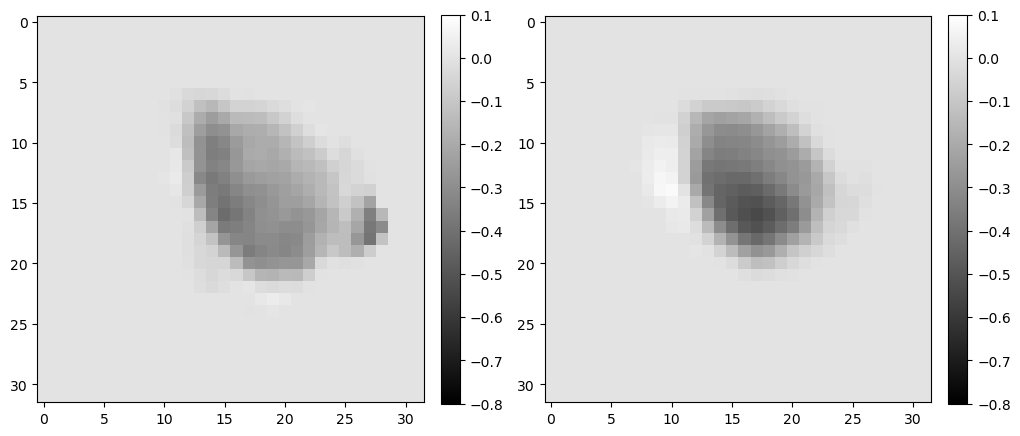

In [369]:
print(input_.shape, out_.shape)
batch_size = 0
time = 5
channel = 1
fig, axs = plt.subplots(1,2, figsize = (12,12))
ax = axs.ravel()

#plt.colorbar(ax[0].imshow(input_[batch_size,channel,:,:,time]), fraction=0.046, pad=0.04)
#plt.colorbar(ax[1].imshow(out_[batch_size,channel,:,:,time]), fraction=0.046, pad=0.04)
plt.colorbar(ax[0].imshow(input_[batch_size,channel,:,:,time], vmin = -0.8, vmax = 0.1, cmap = 'gray'), fraction=0.046, pad=0.04)
plt.colorbar(ax[1].imshow(out_[batch_size,channel,:,:,time], vmin = -0.8, vmax = 0.1, cmap = 'gray'), fraction=0.046, pad=0.04)
#ax[0].imshow(input_[batch_size,channel,:,:,time])
#ax[1].imshow(out_[batch_size,channel,:,:,time])



In [370]:
# Testing the model best checkpoint
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE_convT(in_channels=4, gf_dim=8).to(device)

best_epoch_model = glob.glob(experiment_path + '/' + '*best*')[0]

torch.Size([10, 256, 2, 2, 3])
torch.Size([10, 4, 32, 32, 24])


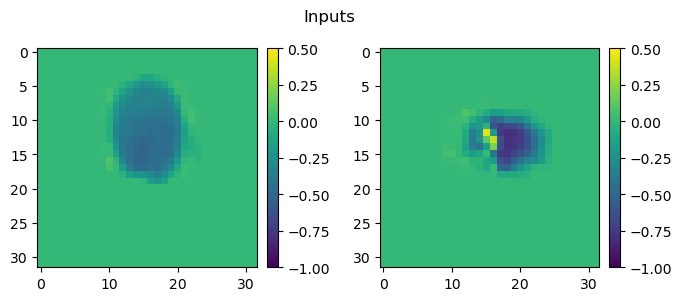

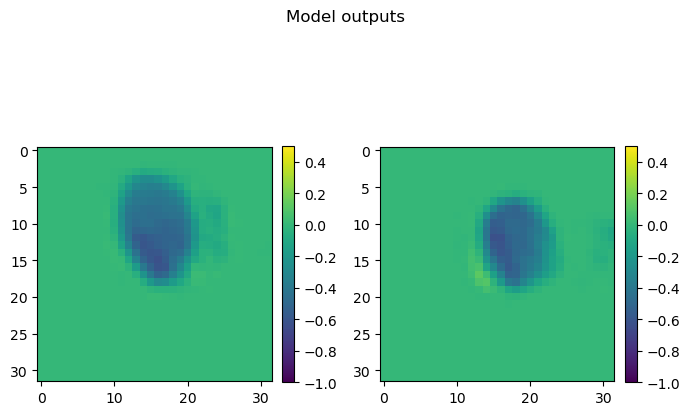

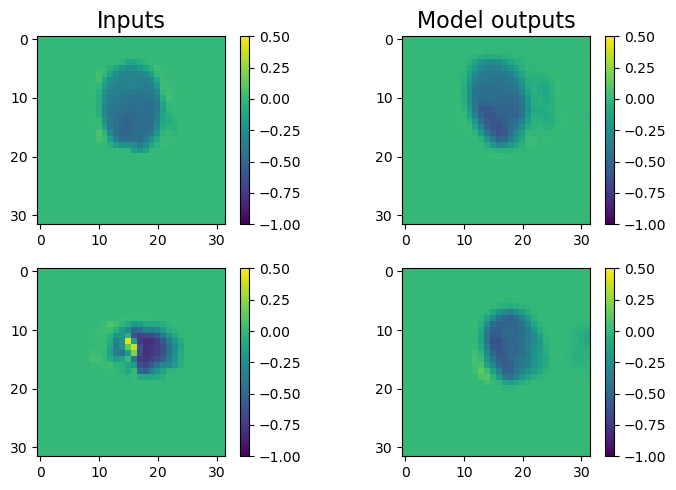

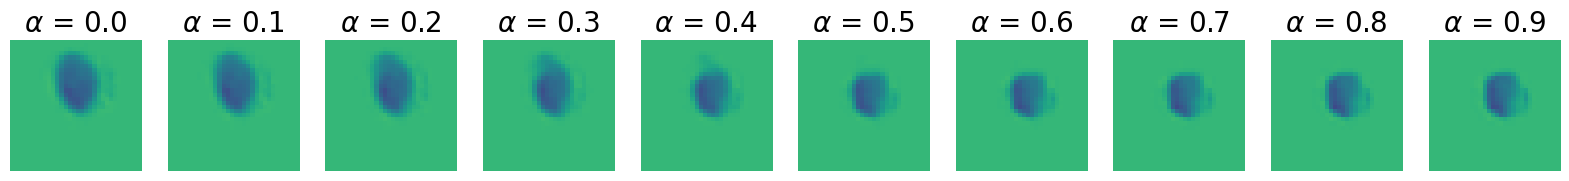

In [389]:
viz(images, best_epoch_model, c = 1, t = 3, scale_colorbar = True, i1=32, i2=144)

#### Model with best validation loss

In [120]:
best_val_model = '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0'
best_val_sweep = 'rkinsla9'
log_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/logs/vae/masked_slice'
if best_val_sweep:
    best_val_log_path = os.path.join(log_path, best_val_sweep)
best_val_experiment_path = os.path.join(best_val_log_path, best_val_model)
os.listdir(best_val_experiment_path)

['intermediate_results',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-0',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-best',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-10',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-20',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-30',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-40',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-50',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-60',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-70']

In [43]:
best_gen_model = '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0'
best_gen_sweep = 'rkinsla9'
log_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/logs/vae/masked_slice'
if best_gen_sweep:
    best_gen_log_path = os.path.join(log_path, best_gen_sweep)
best_gen_experiment_path = os.path.join(best_gen_log_path, best_gen_model)
os.listdir(best_gen_experiment_path)

['intermediate_results',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-0',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-best',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-10',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-20',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-30',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-40',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-50',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-60',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-70']

#### Interpolation

In [44]:
best_val_model_path = glob.glob(best_val_experiment_path + '/' + '*best*')[0]
best_gen_model_path = glob.glob(best_gen_experiment_path + '/' + '*best*')[0]

torch.Size([10, 256, 2, 2, 3])
torch.Size([10, 4, 32, 32, 24])


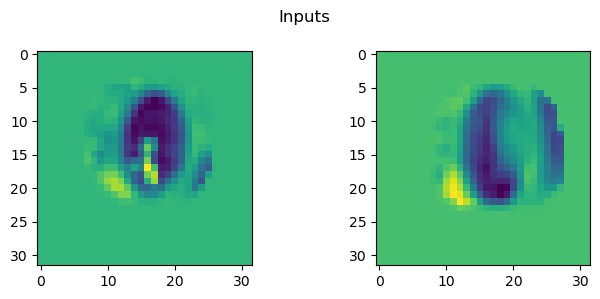

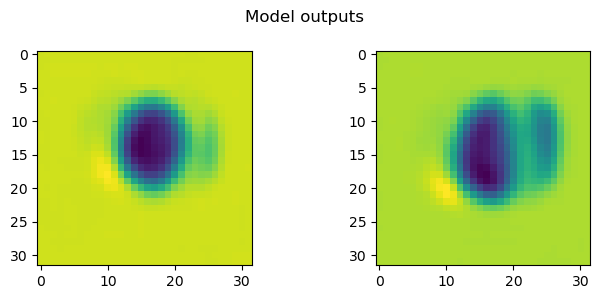

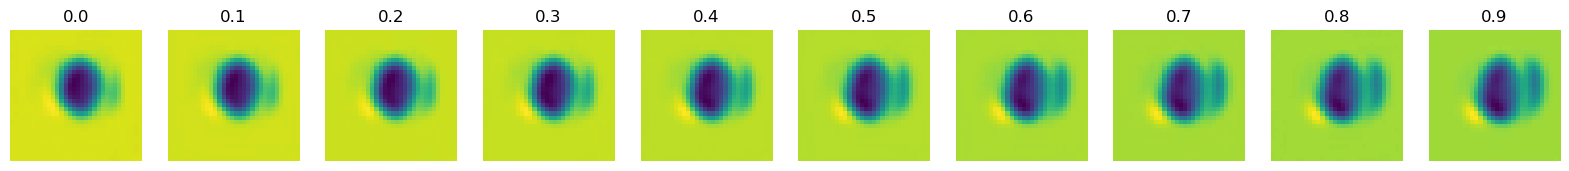

In [45]:
viz(images, best_val_model_path, c = 1, t = 3, scale_colorbar=False)

torch.Size([10, 256, 2, 2, 3])
torch.Size([10, 4, 32, 32, 24])


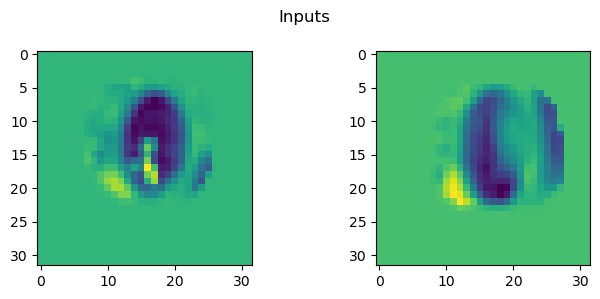

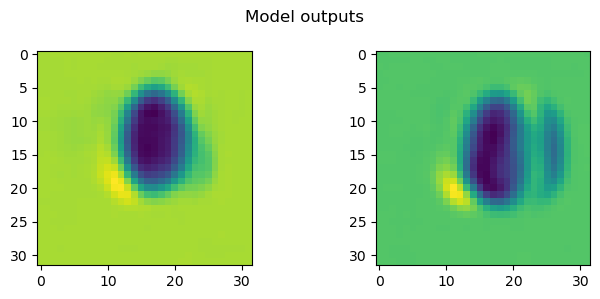

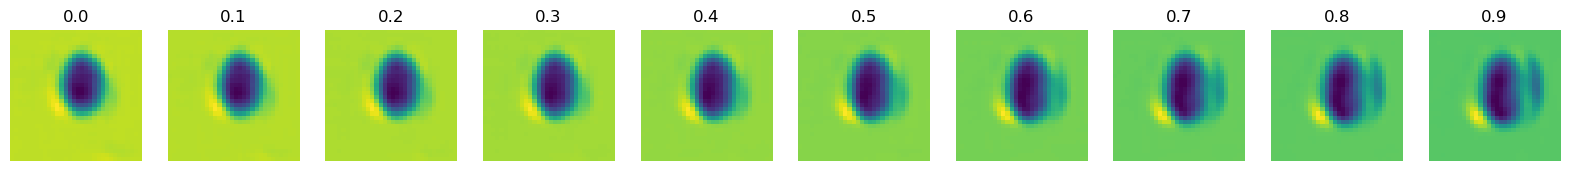

In [46]:
viz(images, best_gen_model_path, c = 1, t = 3, scale_colorbar= False)

torch.Size([10, 256, 2, 2, 3])
torch.Size([10, 4, 32, 32, 24])


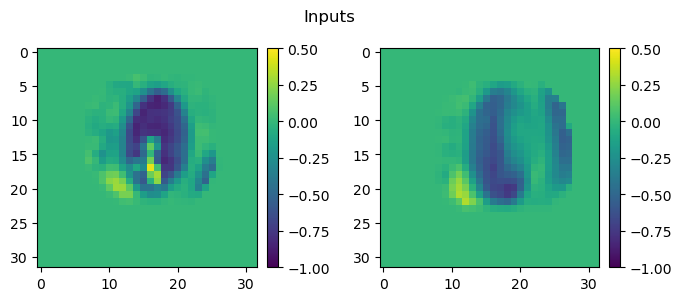

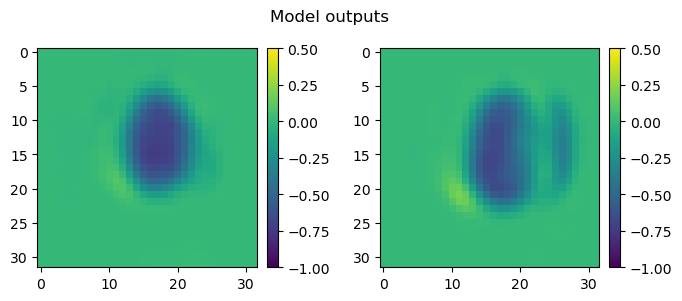

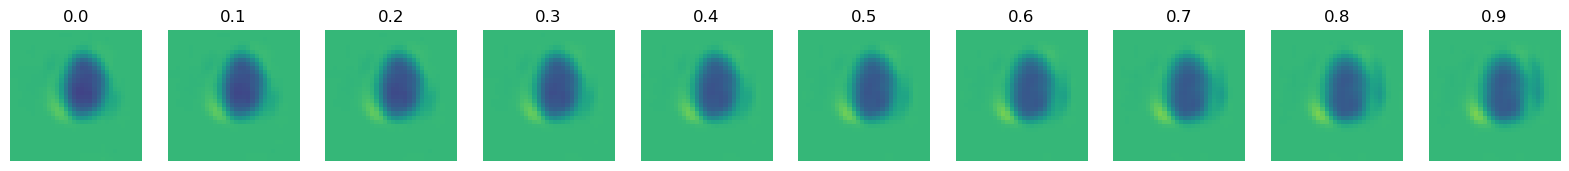

In [47]:
viz(images, best_gen_model_path, c = 1, t = 3, scale_colorbar= True)